<a href="https://colab.research.google.com/github/as147108/PointOfSale/blob/master/Crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import YOLO and setting

In [1]:
! nvidia-smi

Sat Jun  5 15:51:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

clone darknet

In [2]:
! git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5934, done.
remote: Total 5934 (delta 0), reused 0 (delta 0), pack-reused 5934
Receiving objects: 100% (5934/5934), 6.35 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (3924/3924), done.


查看YOLO GPU配置

In [3]:
! cd darknet; head Makefile

GPU=0
CUDNN=0
OPENCV=0
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


設定YOLO GPU配置

In [4]:
!sed -i "s/GPU=0/GPU=1/g" darknet/Makefile
!sed -i "s/CUDNN=0/CUDNN=1/g" darknet/Makefile
!sed -i "s/OPENCV=0/OPENCV=1/g" darknet/Makefile

In [5]:
! head darknet/Makefile

GPU=1
CUDNN=1
OPENCV=1
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


CUDA 10.2 後已經不支援 compute_30 改成 compute_35

In [6]:
makefiletemp = open('darknet/Makefile','r+') 
list_of_lines = makefiletemp.readlines()
list_of_lines[6] = list_of_lines[5]
list_of_lines[7] = "ARCH= -gencode arch=compute_35,code=sm_35 \\\n"
print(list_of_lines[15])
makefiletemp = open('darknet/Makefile','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

VPATH=./src/:./examples



編譯

In [7]:
! cd darknet; make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:967:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN 

# 物件辨識測試

呼叫darknet function

In [8]:
! cd darknet ; ./darknet

usage: ./darknet <function>


下載YOLO權重參數檔(模型設定檔)

In [9]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2021-06-05 15:52:46--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  45.2MB/s    in 0.7s    

2021-06-05 15:52:47 (45.2 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



 預覽要辨識的Image

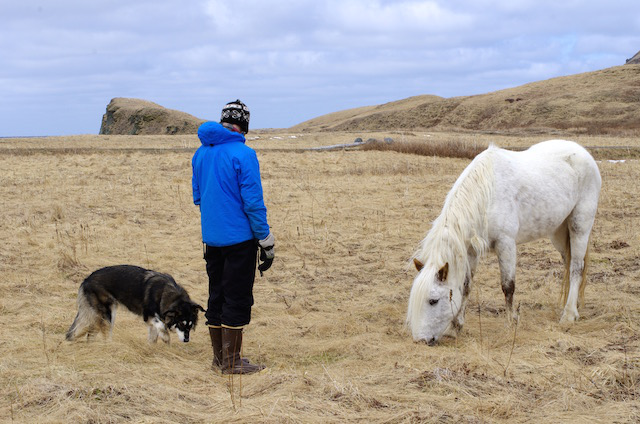

In [10]:
from PIL import Image
Image.open('darknet/data/person.jpg')

偵測Object-->呼叫CNN(卷積神經網路)


In [11]:
! cd darknet; ./darknet detect cfg/yolov3-tiny.cfg ../yolov3-tiny.weights data/person.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

辨識完成圖片檔案路徑:darknet/predictions.jpg

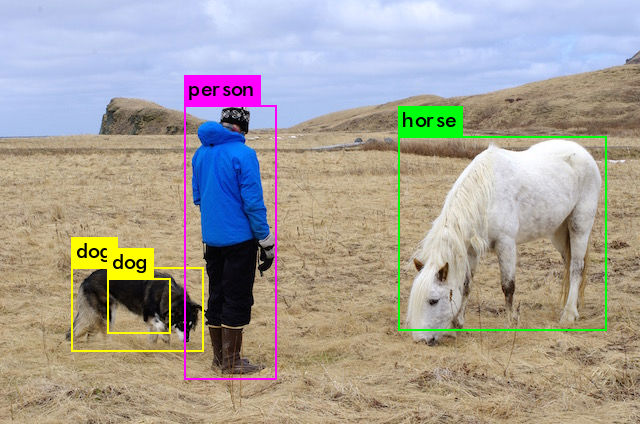

In [12]:
from PIL import Image
Image.open('darknet/predictions.jpg')

# 新增辨識模型

連接 Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
 cp "/content/drive/My Drive/CropDataSet/CropDataSet.7z" /content/

In [16]:
!p7zip -d /content/CropDataSet.7z > data_unzip.log

In [17]:
! cat /content/CropDataSet/cropYOLO/agri_0_1009.txt

1 0.608398 0.498047 0.541016 0.531250


新增 train 資料集 (80%)

In [18]:
import os
datasets = ['/content/CropDataSet/cropYOLO/'+ f for f in os.listdir('/content/CropDataSet/cropYOLO/') if not f.endswith('.txt')]
len(datasets) * 0.8

1040.0

In [19]:
with open('/content/CropDataSet/cfg/train.txt', 'w') as f:
    f.write('\n'.join(datasets[0:540]))

新增 test 資料集 (20%)

In [20]:
with open('/content/CropDataSet/cfg/test.txt', 'w') as f:
    f.write('\n'.join(datasets[0:540]))

檢查

In [21]:
cp "/content/drive/My Drive/CropDataSet/darknet53.conv.74" /content/CropDataSet/cfg/

In [22]:
! head /content/CropDataSet/cfg/obj.data

classes= 2

train  = cfg.orange/train.txt

valid  = cfg.orange/test.txt

names = /home/digits/jupyter/chtseng/opencv-cascade-make/yolo-v3/cfg.orange/obj.names

backup = cfg.orange/weights/

In [23]:
! head /content/CropDataSet/cfg/obj.names

crop
weed

設定YOLO.cfg

In [24]:
! cp /content/darknet/cfg/yolov3-tiny.cfg /content/CropDataSet/cfg/

In [25]:
! sed -n -e 127p -e 135p -e 171p -e 177p /content/CropDataSet/cfg/yolov3-tiny.cfg

filters=255
classes=80
filters=255
classes=80


In [26]:
! sed -i '127s/255/21/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '135s/80/2/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '171s/255/21/' /content/cfg_mask/yolov3-tiny.cfg
! sed -i '177s/80/2/' /content/cfg_mask/yolov3-tiny.cfg

sed: can't read /content/cfg_mask/yolov3-tiny.cfg: No such file or directory
sed: can't read /content/cfg_mask/yolov3-tiny.cfg: No such file or directory
sed: can't read /content/cfg_mask/yolov3-tiny.cfg: No such file or directory
sed: can't read /content/cfg_mask/yolov3-tiny.cfg: No such file or directory


# 訓練

In [ ]:
! darknet/darknet detector train /content/CropDataSet/cfg/obj.data /content/CropDataSet/cfg/yolov3-tiny.cfg /content/CropDataSet/cfg/darknet53.conv.74